In [1]:
import click
import logging
from pathlib import Path
# from dotenv import find_dotenv, load_dotenv
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.callbacks import TensorBoard
# tensorboard --logdir ./ --host=127.0.0.1
from time import time

print("Tensorflow version:", tf.__version__)

SEQUENCE_LENGTH = 200
VACAB_FEATURES = 100
VOCAB_SIZE = 60064 # 3575 # 3443

train_tokens_file = '../data/processed/train/reviews_21122_tokens_200_sentiment.npy'  # Check SEQUENCE_LENGTH flag
# Load the file
train_array = np.load(train_tokens_file)

Tensorflow version: 1.7.0


In [2]:
review_text_array = train_array

# Shuffle the array
np.random.shuffle(review_text_array)

# Prepare tokenizer
t = keras.preprocessing.text.Tokenizer()
t.fit_on_texts(review_text_array[0:, 0])
text_seq = t.texts_to_sequences(review_text_array[0:, 0])
vocab_size = len(t.word_index) + 1
print('Vocabulary size : {}'.format(vocab_size))

assert(len(t.word_index) + 1 <= VOCAB_SIZE)
assert(max([len(iner_list) for iner_list in text_seq]) == SEQUENCE_LENGTH)

Vocabulary size : 60064


In [3]:
print('Word index: ')
print(t.word_index)


Word index: 
{'br': 1, 'movie': 2, 'film': 3, 'one': 4, 'like': 5, 'good': 6, 'time': 7, 'really': 8, 'would': 9, 'story': 10, 'see': 11, 'even': 12, 'well': 13, 'bad': 14, 'great': 15, 'much': 16, 'people': 17, 'get': 18, 'movies': 19, 'made': 20, 'first': 21, 'also': 22, 'watch': 23, 'could': 24, 'make': 25, 'think': 26, 'way': 27, 'acting': 28, 'seen': 29, 'plot': 30, 'characters': 31, 'show': 32, 'love': 33, 'best': 34, 'films': 35, 'ever': 36, 'many': 37, 'character': 38, 'life': 39, 'little': 40, 'better': 41, 'never': 42, 'know': 43, 'two': 44, 'end': 45, 'say': 46, 'still': 47, 'watching': 48, 'scenes': 49, 'man': 50, 'go': 51, 'funny': 52, 'actors': 53, 'something': 54, '10': 55, 'scene': 56, 'back': 57, 'real': 58, 'thing': 59, 'old': 60, 'years': 61, 'nothing': 62, 'though': 63, 'actually': 64, 'work': 65, 'director': 66, 'lot': 67, 'cast': 68, 'makes': 69, 'find': 70, 'look': 71, 'want': 72, 'every': 73, 'another': 74, 'going': 75, 'new': 76, 'pretty': 77, 'part': 78, 'got'

In [4]:
print('Input before padding: ','=====================', sep='\n' )
for s in text_seq[0:3]:
    print(s) 


Input before padding: 
[21727, 28961, 15402, 1802, 13624, 306, 7499, 617, 429, 19, 13, 902, 281, 2030, 872, 28, 551, 22, 872, 28, 551, 3811, 380, 9853, 1028, 28962, 290, 2062, 249, 113, 13624, 1688, 2441, 64, 11, 125, 1701, 1468, 245, 175, 932, 21727, 28961, 16563, 2251, 3333, 148, 167, 528, 229, 10, 1903, 14, 73, 526, 27, 17, 26, 14, 52, 4, 139, 787, 225, 7, 148]
[80, 2, 1225, 126, 429, 30, 229, 1044, 8365, 1616, 844, 2, 956, 7500, 124, 53, 24607, 19604, 1608, 95, 4162, 36781, 2598, 6362, 19605, 30, 471, 399, 2527, 6086, 10258, 2351, 56, 45, 10259, 20, 3242, 944, 2527, 12, 153, 471, 24, 254, 1236, 5992, 1133, 1840, 174, 943, 974, 229, 9191, 65, 1840, 2002, 2463, 1070, 174, 3089, 5769, 112, 2, 285, 5, 739, 7, 39, 2, 124, 4292, 32, 5992, 1133, 386, 2165, 5450, 224, 2085, 511, 32, 8, 28963, 423]
[80, 3, 16564, 1792, 466, 3, 1057, 11145, 822, 783, 17898, 17899, 4844, 28964, 76, 12894, 3, 311, 16564, 271, 2069, 118, 130, 7688, 1079, 11146, 530, 246, 6363, 1259, 573, 1532, 784, 592, 17898, 

In [5]:
# Padding Sequences
input_seq_padded = keras.preprocessing.sequence.pad_sequences(text_seq, maxlen=SEQUENCE_LENGTH)
print('Input shape after padding: ', input_seq_padded.shape)
print('Sample: ', type(input_seq_padded))
print(input_seq_padded[0:1])

# Get the maximum element from a Numpy array
max_element = np.amax(input_seq_padded)
print('Maximum element: ', max_element)

# Input data type conversion
input_seq_normalized = np.asarray(input_seq_padded, dtype=np.float)

# Output data type conversion
output = np.asarray(review_text_array[0:, 2], dtype=np.float)
# As the scores are in 1-10 we need to transform to 0-9 for categorical
# output -= 1
output_y = keras.utils.to_categorical(output, num_classes=2)

Input shape after padding:  (21122, 200)
Sample:  <class 'numpy.ndarray'>
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0 21727 28961 15402  1802 13624   306  7499   617   429    19
     13   902   281  2030   872    28 

In [6]:

train_x = input_seq_normalized
train_y = output_y

print('Sample Train Input: ')
print(train_x[0:1])
print('Sample Train Output: ')
print(train_y[0:1])


Sample Train Input: 
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0

In [7]:
deep_inputs = keras.layers.Input(shape=(SEQUENCE_LENGTH, ))
embedding = keras.layers.Embedding(VOCAB_SIZE, VACAB_FEATURES, input_length=SEQUENCE_LENGTH)(deep_inputs)
dropout = keras.layers.Dropout(0.2)(embedding)
lstm_1 = keras.layers.LSTM(units=100, return_sequences=True)(dropout)  # batch_input_shape=[None, SEQUENCE_LENGTH, VACAB_FEATURES]
lstm_2 = keras.layers.LSTM(units=100, return_sequences=False)(lstm_1)  # batch_input_shape=[None, SEQUENCE_LENGTH, VACAB_FEATURES],
final_dense = keras.layers.Dense(2, activation='softmax')(lstm_2)
deep_model = keras.Model(inputs=deep_inputs, outputs=final_dense)
print(deep_model.summary())

# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
deep_model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

history = deep_model.fit(train_x, train_y, batch_size=100, 
                         epochs=5, 
                         validation_split=.2,
                         ) # callbacks=[tensorboard]

# history = deep_model.fit(train_x, train_y, batch_size=100,
#                          epochs=50,
#                          validation_data=(test_x, test_y))

# scores = deep_model.evaluate(test_x, test_y, verbose=0)
# print('Test accuracy:', scores[1])
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          6006400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 6,167,402
Trainable params: 6,167,402
Non-trainable params: 0
_________________________________________________________________


#### Save the Model

In [ ]:
file = 'model_reviews_21122_tokens_200_sentiment.h5'
deep_model.save(file)

#### Load the Model

In [38]:
# deep_model = keras.models.load_model(file)

#### Extract the Embadding layer Weights

In [17]:
emb_layer = deep_model.get_layer('embedding_1')
(w,) = emb_layer.get_weights()
# w = np.array(emb_layer.get_weights())
w.shape

(60064, 100)

In [9]:
print('Embedding layer matrix:','=======================','VOCAB_SIZE x FEATURE {}'.format(w.shape), sep='\n')

Embedding layer matrix:
VOCAB_SIZE x FEATURE (1, 60064, 100)


In [95]:
print('Embedding-Vector for first 2 WORDS:','===================================', sep='\n')
print(w[0,0:2,0:100 ])

Embedding Vector for first 2 WORDS:
[[ 0.1901829   0.6710398   0.5247769   0.69856644  0.07382236  0.6220557
   0.39801374  0.49428633  0.92396057 -0.00900462  0.6458018   0.7890908
   0.02740984  0.01363969  0.8130527   0.54807645  0.70979923  0.14380175
   0.57947135  0.40962216  0.71734995  0.8043898   0.24038018  0.36719543
   0.9201319   0.336245    0.01552014  0.16350771  0.09198275  0.19251858
   0.70731986  0.39076748  0.8340259   0.9184222   0.4143255   0.8066756
   0.16529705  0.50788355  0.51578987  0.9196982   0.79997814  0.2656864
   0.08013505  0.02108148  0.7600859   0.27438366  0.86335987  1.009643
  -0.00964903  0.19519894  0.22787486  0.7102592   0.83677745  0.10949637
   0.6080416   0.92538744  0.4637305   0.9816504   0.29984438  0.3946031
   0.17057443  0.91000706  0.542012    0.04178032  0.39390928  0.4089889
   0.8828766   0.22671795  0.00713791  0.02932093  1.0446905   0.44868472
   0.09384533  0.16818541  0.6956841   0.09921628  0.08774389  0.14020133
   0.82710

In [10]:
train_x.shape

(21122, 200)

In [12]:
np.asarray(train_x[0:1,], dtype=np.int)

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [14]:
from gensim.models.keyedvectors import WordEmbeddingsKeyedVectors

In [18]:
embedding_size = w.shape[1]
kv = WordEmbeddingsKeyedVectors(embedding_size)

In [16]:
print('Word index: ', '===========', sep='\n')
print(t.word_index)

Word index: 
{'br': 1, 'movie': 2, 'film': 3, 'one': 4, 'like': 5, 'good': 6, 'time': 7, 'really': 8, 'would': 9, 'story': 10, 'see': 11, 'even': 12, 'well': 13, 'bad': 14, 'great': 15, 'much': 16, 'people': 17, 'get': 18, 'movies': 19, 'made': 20, 'first': 21, 'also': 22, 'watch': 23, 'could': 24, 'make': 25, 'think': 26, 'way': 27, 'acting': 28, 'seen': 29, 'plot': 30, 'characters': 31, 'show': 32, 'love': 33, 'best': 34, 'films': 35, 'ever': 36, 'many': 37, 'character': 38, 'life': 39, 'little': 40, 'better': 41, 'never': 42, 'know': 43, 'two': 44, 'end': 45, 'say': 46, 'still': 47, 'watching': 48, 'scenes': 49, 'man': 50, 'go': 51, 'funny': 52, 'actors': 53, 'something': 54, '10': 55, 'scene': 56, 'back': 57, 'real': 58, 'thing': 59, 'old': 60, 'years': 61, 'nothing': 62, 'though': 63, 'actually': 64, 'work': 65, 'director': 66, 'lot': 67, 'cast': 68, 'makes': 69, 'find': 70, 'look': 71, 'want': 72, 'every': 73, 'another': 74, 'going': 75, 'new': 76, 'pretty': 77, 'part': 78, 'got'

In [24]:
t.word_index['movie']

2

In [28]:
list(t.word_index.keys())

['br',
 'movie',
 'film',
 'one',
 'like',
 'good',
 'time',
 'really',
 'would',
 'story',
 'see',
 'even',
 'well',
 'bad',
 'great',
 'much',
 'people',
 'get',
 'movies',
 'made',
 'first',
 'also',
 'watch',
 'could',
 'make',
 'think',
 'way',
 'acting',
 'seen',
 'plot',
 'characters',
 'show',
 'love',
 'best',
 'films',
 'ever',
 'many',
 'character',
 'life',
 'little',
 'better',
 'never',
 'know',
 'two',
 'end',
 'say',
 'still',
 'watching',
 'scenes',
 'man',
 'go',
 'funny',
 'actors',
 'something',
 '10',
 'scene',
 'back',
 'real',
 'thing',
 'old',
 'years',
 'nothing',
 'though',
 'actually',
 'work',
 'director',
 'lot',
 'cast',
 'makes',
 'find',
 'look',
 'want',
 'every',
 'another',
 'going',
 'new',
 'pretty',
 'part',
 'got',
 'saw',
 'thought',
 'comedy',
 'quite',
 'give',
 'big',
 'world',
 'young',
 'action',
 'things',
 'series',
 'interesting',
 'however',
 'original',
 'horror',
 'times',
 'long',
 'must',
 'us',
 'enough',
 'worst',
 'family',
 'seem

In [30]:
list(t.word_index.values())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [23]:
w[t.word_index['movie']]

array([ 0.8538847 ,  0.6449934 ,  0.02004006,  0.7824123 ,  0.7513072 ,
       -0.1223381 ,  0.6861222 ,  0.8971158 ,  0.40099487,  0.9303634 ,
        0.36533746, -0.01775187,  0.23931839,  0.4079482 ,  0.48784733,
        0.73065877,  0.8978188 ,  0.4426171 ,  0.17439982,  0.71799386,
        0.85990214,  0.888779  ,  0.8393122 ,  0.12900731,  0.01455493,
        0.70856285,  0.2596319 ,  0.63563114,  0.10767289,  0.04517074,
        0.7705392 ,  0.16304454,  0.3780913 ,  0.738803  ,  0.2529928 ,
        0.16038764,  0.63203853,  0.9284537 ,  0.10217873,  0.6872468 ,
        0.19265942,  0.6445559 ,  0.9046764 ,  0.20489621,  0.96705556,
        0.6661686 ,  0.37196112,  0.57200235,  0.28043303,  1.1384777 ,
        0.38805497,  0.393062  ,  0.622306  ,  0.6971102 ,  0.52432305,
        0.55048084,  0.46341795,  0.84040993,  0.05618595,  0.60861564,
        0.5655406 ,  0.24557962,  0.73775023,  0.937532  ,  0.69523424,
        0.52521354,  0.7565244 ,  0.23888688,  0.9558552 ,  0.66

In [31]:
kv.add(list(t.word_index.keys()), w[list(t.word_index.values())])

In [35]:
kv.most_similar('work')

[('sacarstic', 0.8617643117904663),
 ('lego', 0.8526730537414551),
 ('dreamworks', 0.8517913818359375),
 ('clansmen', 0.8464169502258301),
 ('narratively', 0.8453619480133057),
 ('vaginal', 0.8447957038879395),
 ('upa', 0.8435620069503784),
 ('emit', 0.8425333499908447),
 ('harvest', 0.8420920372009277),
 ('joking', 0.8412215709686279)]

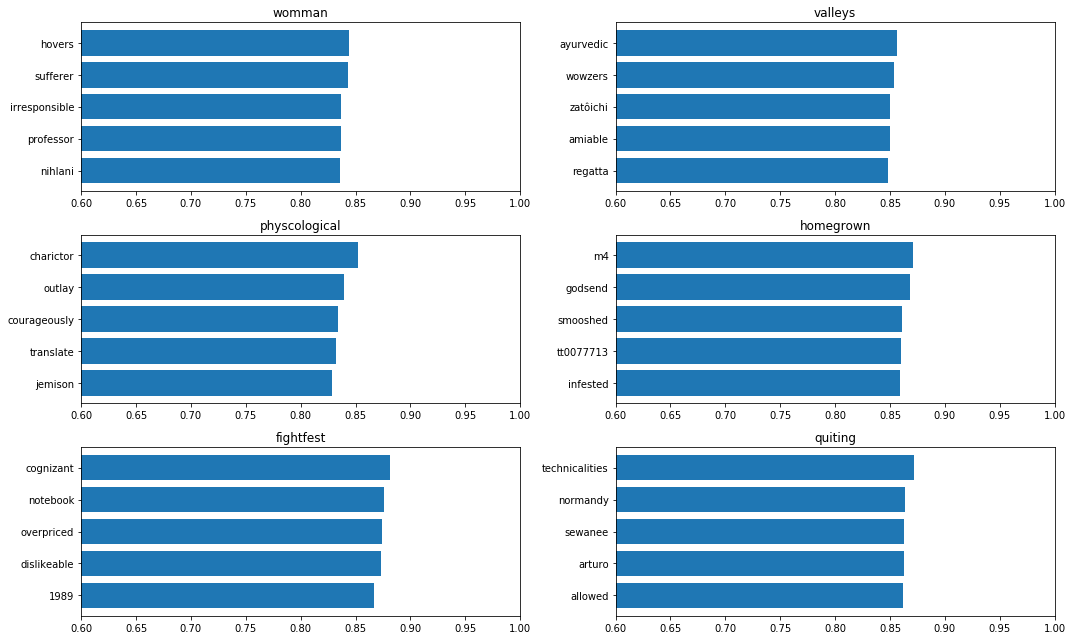

In [41]:
import textwrap
from matplotlib import pyplot as plt
movies = ['womman', 'valleys', 'physcological', 'homegrown',
          'fightfest', 'quiting']

def plot_most_similar(movie, ax, topn=5):
    sim = kv.most_similar(movie, topn=topn)[::-1]
    y = np.arange(len(sim))
    w = [t[1] for t in sim]
    ax.barh(y, w)
    left = min(.6, min(w))
    ax.set_xlim(right=1.0, left=left)
    # Split long titles over multiple lines
    labels = [textwrap.fill(t[0] , width=24)
              for t in sim]
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_title(movie)    

fig, axes = plt.subplots(3, 2, figsize=(15, 9))

for movie, ax in zip(movies, axes.flatten()):
    plot_most_similar(movie, ax)
    
fig.tight_layout()